<h2>Linear Regression Analysis of Murder Rate by US State</h2>

<h4>Input Variables</h4>

<ul>
<li>population density</li>
<li>household income</li>
<li>poverty rate</li>
<li>education</li>
<li>suicide rate</li>
<li>incarceration rate</li>
</ul>

<h4>Output Variable</h4>
<ul>
<li>murder rate</li>
</ul>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

<a href="http://en.wikipedia.org/wiki/Gun_violence_in_the_United_States_by_state">Gun Violence in the US by State</a>

In [2]:
guns = pd.read_csv("data/guns.csv")
guns = guns[guns.state != 'District of Columbia']

<a href="http://en.wikipedia.org/wiki/List_of_U.S._states_by_income">List of US States by Income</a>

In [3]:
# DC already removed
income = pd.read_csv('data/household_income_2010.txt')
combined = guns.merge(income[['state', 'income']], on='state')

<a href="http://en.wikipedia.org/wiki/List_of_U.S._states_by_educational_attainment">List of US States by Educational Attainment</a>

In [4]:
# DC already removed
education = pd.read_csv('data/education.csv')
combined = combined.merge(education[['state', 'high_school', 'bachelors', 'advanced']], on='state')
combined['no_high_school'] = 100. - combined['high_school']

<a href="http://usatoday30.usatoday.com/news/health/2007-11-28-depression-suicide-numbers_N.htm">Depression Suicide Numbers</a>

In [5]:
suicide = pd.read_csv('data/suicide.csv')
combined = combined.merge(suicide[['state', 'suicide_rate']], on='state')

<a href="http://en.wikipedia.org/wiki/List_of_U.S._states_by_incarceration_rate">List of US States by Incarceration</a>

In [6]:
incarceration = pd.read_csv('data/incarceration.csv')
combined = combined.merge(incarceration[['state','incarceration_rate']], on='state')

<a href="https://www.census.gov/statab/ranks/rank21.html">Violent Crimes per US State</a>

In [7]:
violence = pd.read_csv('data/violence.csv')
combined = combined.merge(violence[['state','violent_crime_rate']], on='state')

<a href="http://en.wikipedia.org/wiki/List_of_U.S._states_by_poverty_rate">List of US States by Poverty Rate</a>

In [8]:
poverty = pd.read_csv('data/poverty.csv')
combined = combined.merge(poverty[['state','poverty_rate']], on='state')

In [9]:
primary_cols = ['murder_rate', 'population_density', 'high_school', 'suicide_rate', 'incarceration_rate', 'poverty_rate', 
                'income', 'gun_ownership']

In [10]:
print combined.columns
combined[primary_cols].corr()

Index([u'state', u'population', u'population_density', u'murders', u'gun_murders', u'gun_ownership', u'murder_rate', u'gun_murder_rate', u'income', u'high_school', u'bachelors', u'advanced', u'no_high_school', u'suicide_rate', u'incarceration_rate', u'violent_crime_rate', u'poverty_rate'], dtype='object')


,murder_rate,population_density,high_school,suicide_rate,incarceration_rate,poverty_rate,income,gun_ownership
murder_rate,1.000000,0.139420,-0.669136,-0.081453,0.655537,0.515520,-0.190506,-0.119836
population_density,0.139420,1.000000,-0.046725,-0.641630,-0.270220,-0.289172,0.496774,-0.739535
high_school,-0.669136,-0.046725,1.000000,0.115563,-0.626972,-0.766861,0.446929,0.015967
suicide_rate,-0.081453,-0.641630,0.115563,1.000000,0.203124,0.157947,-0.293510,0.662998
incarceration_rate,0.655537,-0.270220,-0.626972,0.203124,1.000000,0.657218,-0.530396,0.341129
poverty_rate,0.515520,-0.289172,-0.766861,0.157947,0.657218,1.000000,-0.704510,0.349344
income,-0.190506,0.496774,0.446929,-0.293510,-0.530396,-0.704510,1.000000,-0.560928
gun_ownership,-0.119836,-0.739535,0.015967,0.662998,0.341129,0.349344,-0.560928,1.000000


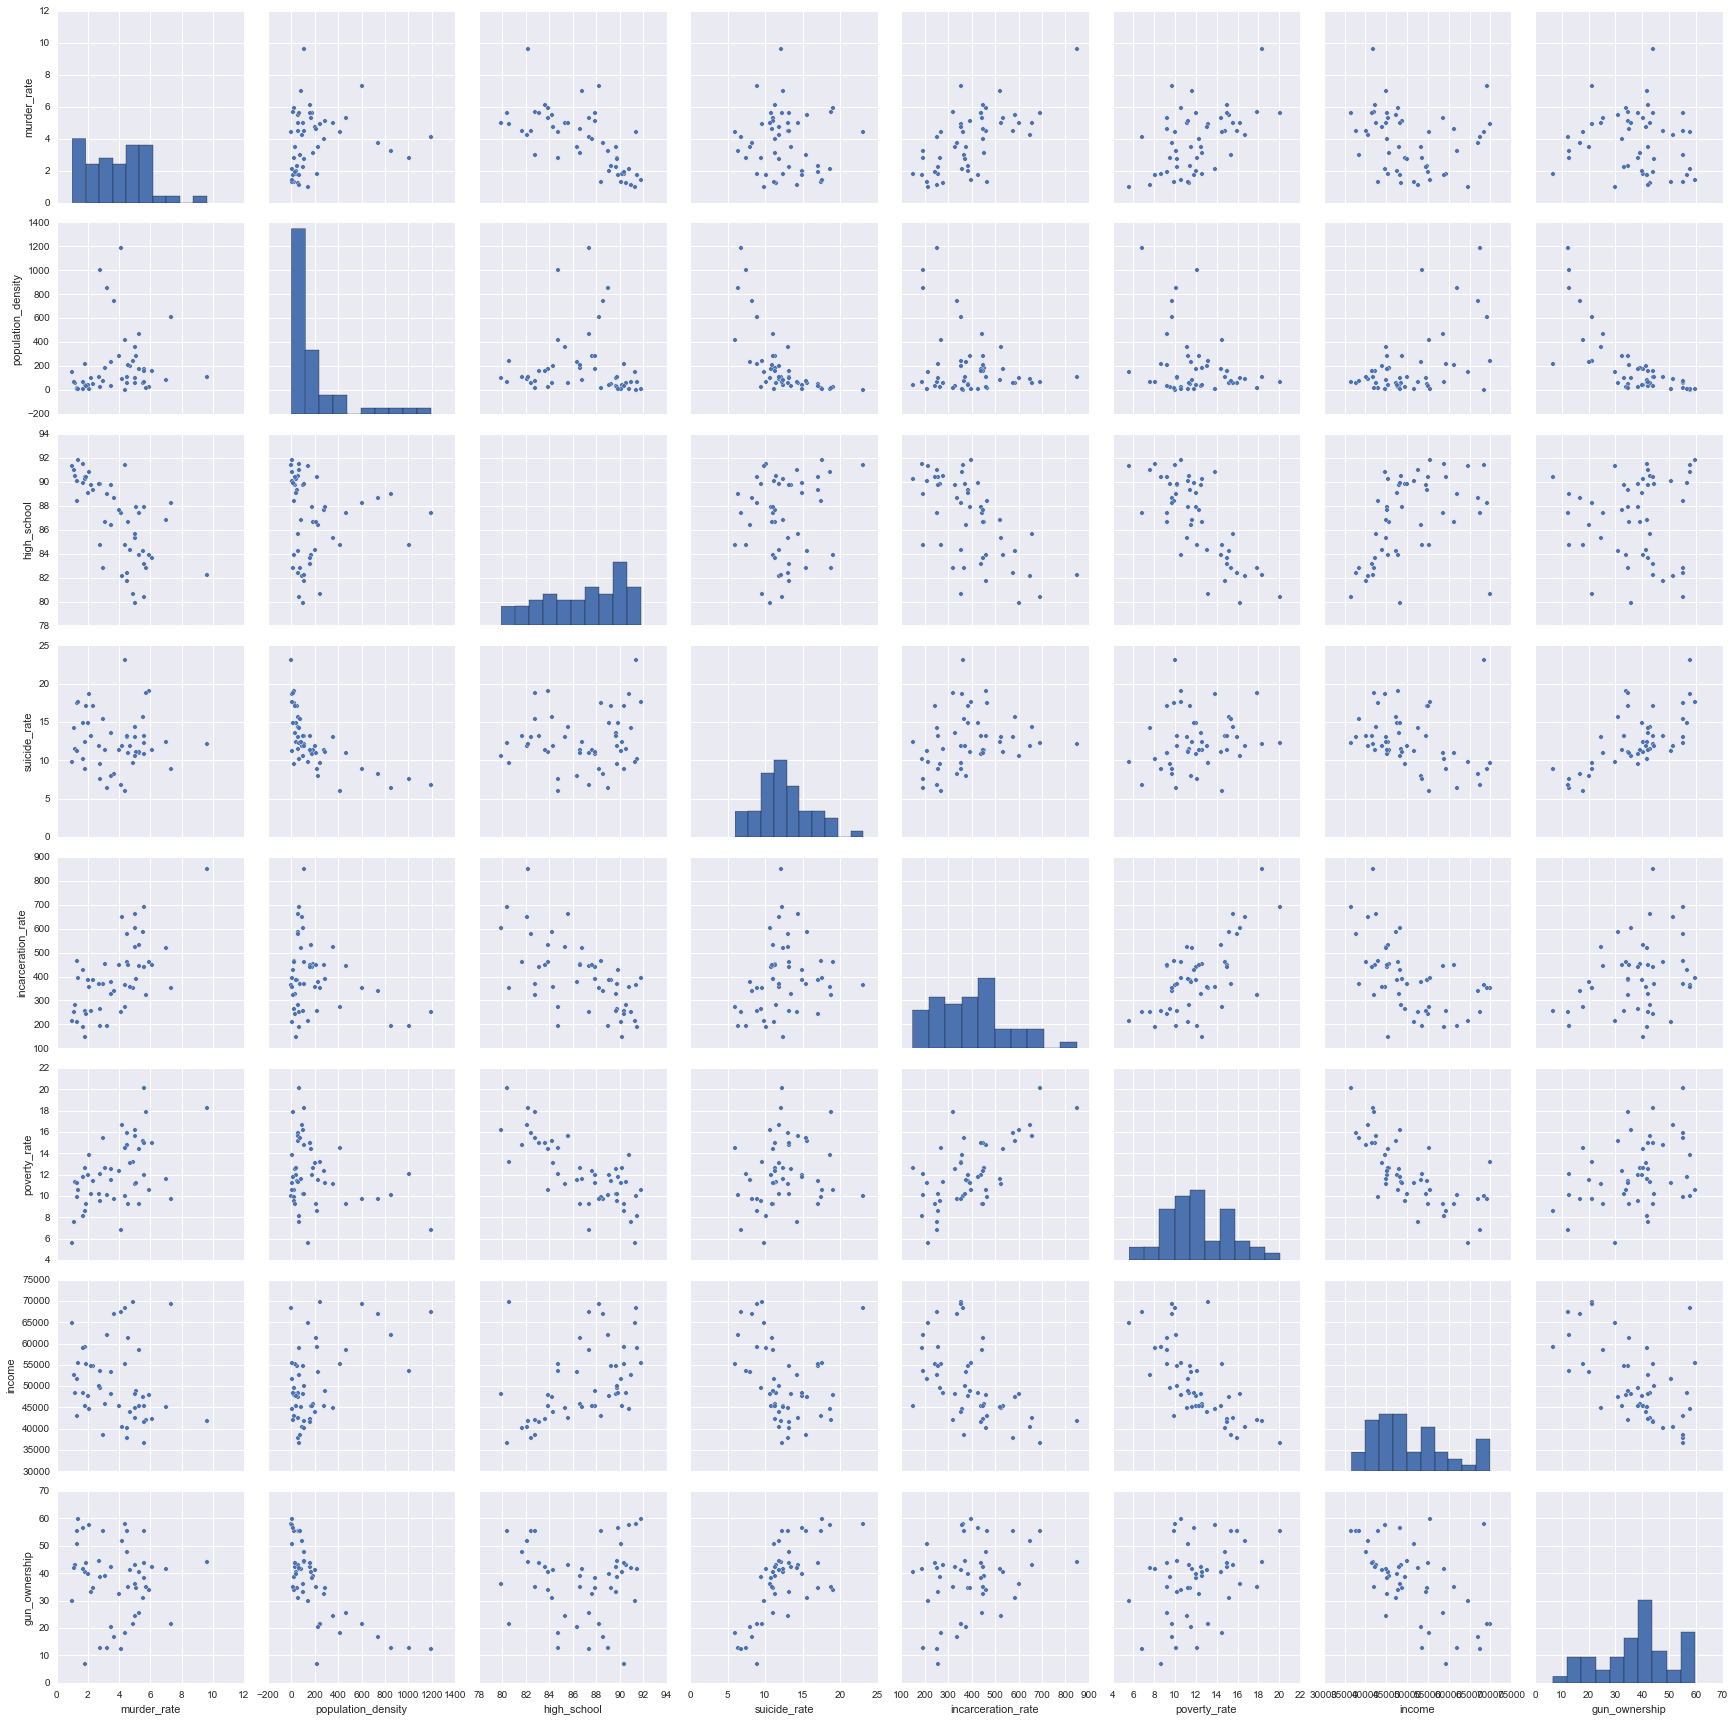

In [11]:
%matplotlib inline
import seaborn as sns
sns.pairplot(combined[primary_cols])
plt.savefig('corr.png')

In [12]:
import sklearn.linear_model as linear_model
import numpy as np
import matplotlib.pyplot as plt

#
# Fit and plot DataFrame columns.
#
def fit_and_plot(df, title, x_col_name, y_col_name, **kwargs):
    
    # Get column data for plot
    x = df[x_col_name].values.reshape(-1,1)
    y = df[y_col_name].values
    
    # Perform OLS fit
    ols_fit = smf.ols(y_col_name + ' ~ ' + y_col_name, data=df).fit()
    print ols_fit.pvalues
    print ols_fit.summary()
    
    # Create linear regression model and perform fit
    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    print "residuals", regr.residues_
    print "Coefficients: \n", regr.coef_

    # The mean square error
    print("Residual sum of squares: %.2f" % np.mean((regr.predict(x) - y) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(x, y))
    print "intercept", regr.intercept_

    plt.axes().grid(b=False)
    plt.axes(axisbg='white')    
    plt.axhline(0, color='black')
    plt.axvline(0, color='black')
    plt.scatter(x, y, color='blue', s=8, alpha=0.8)
    plt.plot(x, regr.predict(x), color='red', linewidth=1, alpha=1.0)
    plt.xlim(xmin=0)
    plt.ylim(ymin=0)
        
    plt.suptitle(title, fontsize=20)
    plt.xlabel(x_col_name.replace('_', ' '), fontsize=12)
    plt.ylabel(y_col_name.replace('_', ' '), fontsize=12)

Intercept      0.001415
murder_rate    0.000000
dtype: float64
                            OLS Regression Results                            
Dep. Variable:            murder_rate   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.696e+32
Date:                Tue, 16 Jun 2015   Prob (F-statistic):               0.00
Time:                        18:03:36   Log-Likelihood:                 1656.4
No. Observations:                  50   AIC:                            -3309.
Df Residuals:                      48   BIC:                            -3305.
Df Model:                           1                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    -1.11e-15   3.28e-16     -3.388      0.001     -1.77e

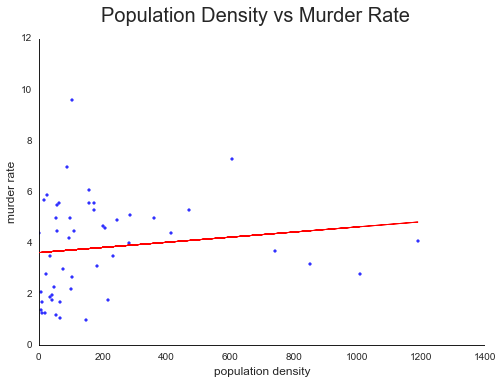

In [13]:
fit_and_plot(combined, 'Population Density vs Murder Rate', 'population_density', 'murder_rate')

Intercept      0.001415
murder_rate    0.000000
dtype: float64
                            OLS Regression Results                            
Dep. Variable:            murder_rate   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.696e+32
Date:                Tue, 16 Jun 2015   Prob (F-statistic):               0.00
Time:                        18:03:37   Log-Likelihood:                 1656.4
No. Observations:                  50   AIC:                            -3309.
Df Residuals:                      48   BIC:                            -3305.
Df Model:                           1                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    -1.11e-15   3.28e-16     -3.388      0.001     -1.77e

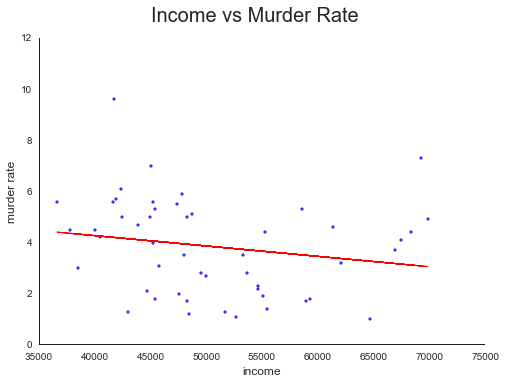

In [14]:
fit_and_plot(combined, 'Income vs Murder Rate', 'income', 'murder_rate')
plt.xlim((35000, 75000))
plt.axvline(35000, color='black')

Intercept      0.001415
murder_rate    0.000000
dtype: float64
                            OLS Regression Results                            
Dep. Variable:            murder_rate   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.696e+32
Date:                Tue, 16 Jun 2015   Prob (F-statistic):               0.00
Time:                        18:03:37   Log-Likelihood:                 1656.4
No. Observations:                  50   AIC:                            -3309.
Df Residuals:                      48   BIC:                            -3305.
Df Model:                           1                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    -1.11e-15   3.28e-16     -3.388      0.001     -1.77e

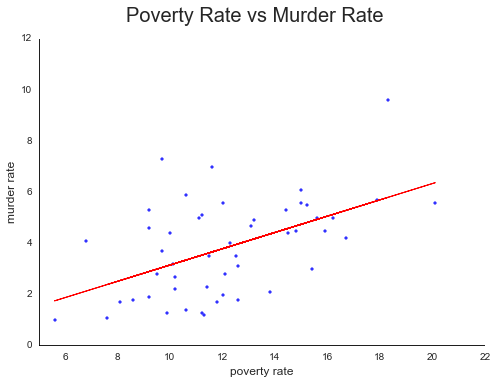

In [15]:
fit_and_plot(combined, 'Poverty Rate vs Murder Rate', 'poverty_rate', 'murder_rate')
plt.xlim((5, 22))
plt.axvline(5, color='black')

Intercept      0.001415
murder_rate    0.000000
dtype: float64
                            OLS Regression Results                            
Dep. Variable:            murder_rate   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.696e+32
Date:                Tue, 16 Jun 2015   Prob (F-statistic):               0.00
Time:                        18:03:37   Log-Likelihood:                 1656.4
No. Observations:                  50   AIC:                            -3309.
Df Residuals:                      48   BIC:                            -3305.
Df Model:                           1                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    -1.11e-15   3.28e-16     -3.388      0.001     -1.77e

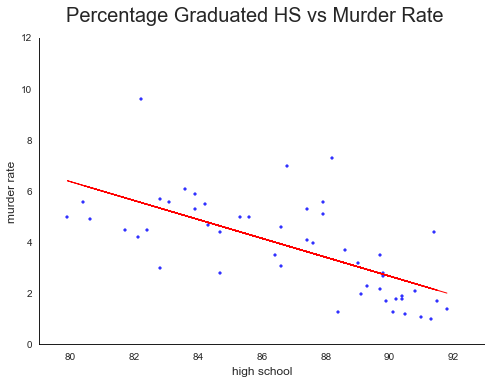

In [16]:
fit_and_plot(combined, 'Percentage Graduated HS vs Murder Rate', 'high_school', 'murder_rate')
plt.xlim((79,93))
plt.axvline(79, color='black')

Intercept      0.001415
murder_rate    0.000000
dtype: float64
                            OLS Regression Results                            
Dep. Variable:            murder_rate   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.696e+32
Date:                Tue, 16 Jun 2015   Prob (F-statistic):               0.00
Time:                        18:03:38   Log-Likelihood:                 1656.4
No. Observations:                  50   AIC:                            -3309.
Df Residuals:                      48   BIC:                            -3305.
Df Model:                           1                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    -1.11e-15   3.28e-16     -3.388      0.001     -1.77e

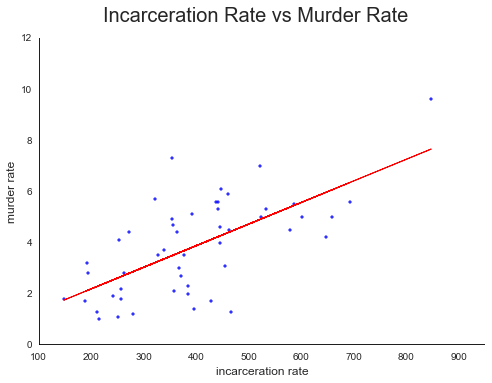

In [17]:
fit_and_plot(combined, 'Incarceration Rate vs Murder Rate', 'incarceration_rate', 'murder_rate')
plt.xlim((100,950))
plt.axvline(100, color='black')
plt.savefig('incarceration.png')

Intercept      0.001415
murder_rate    0.000000
dtype: float64
                            OLS Regression Results                            
Dep. Variable:            murder_rate   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.696e+32
Date:                Tue, 16 Jun 2015   Prob (F-statistic):               0.00
Time:                        18:03:38   Log-Likelihood:                 1656.4
No. Observations:                  50   AIC:                            -3309.
Df Residuals:                      48   BIC:                            -3305.
Df Model:                           1                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    -1.11e-15   3.28e-16     -3.388      0.001     -1.77e

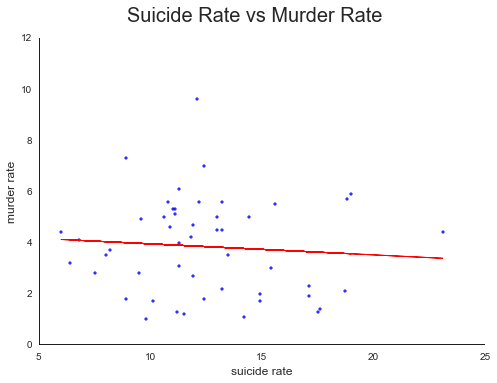

In [18]:
fit_and_plot(combined, 'Suicide Rate vs Murder Rate', 'suicide_rate', 'murder_rate')
plt.xlim((5,25))
plt.axvline(5, color='black')

Intercept      0.001415
murder_rate    0.000000
dtype: float64
                            OLS Regression Results                            
Dep. Variable:            murder_rate   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.696e+32
Date:                Tue, 16 Jun 2015   Prob (F-statistic):               0.00
Time:                        18:03:38   Log-Likelihood:                 1656.4
No. Observations:                  50   AIC:                            -3309.
Df Residuals:                      48   BIC:                            -3305.
Df Model:                           1                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    -1.11e-15   3.28e-16     -3.388      0.001     -1.77e

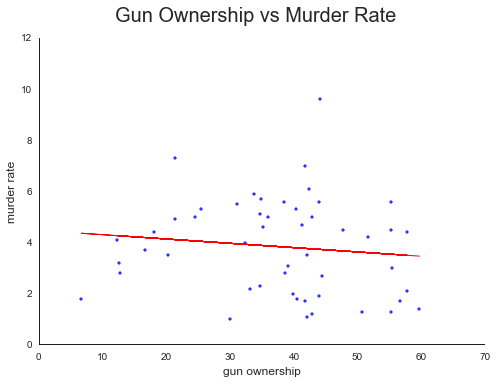

In [19]:
fit_and_plot(combined, 'Gun Ownership vs Murder Rate', 'gun_ownership', 'murder_rate')
#plt.xlim((5,25))
#plt.axvline(5, color='black')

<a href="http://stackoverflow.com/questions/7586384/color-states-with-pythons-matplotlib-basemap">Color States with Python's Matplotlib Basemap</a>

Intercept      0.001415
murder_rate    0.000000
dtype: float64
                            OLS Regression Results                            
Dep. Variable:            murder_rate   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.696e+32
Date:                Tue, 16 Jun 2015   Prob (F-statistic):               0.00
Time:                        18:03:39   Log-Likelihood:                 1656.4
No. Observations:                  50   AIC:                            -3309.
Df Residuals:                      48   BIC:                            -3305.
Df Model:                           1                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    -1.11e-15   3.28e-16     -3.388      0.001     -1.77e

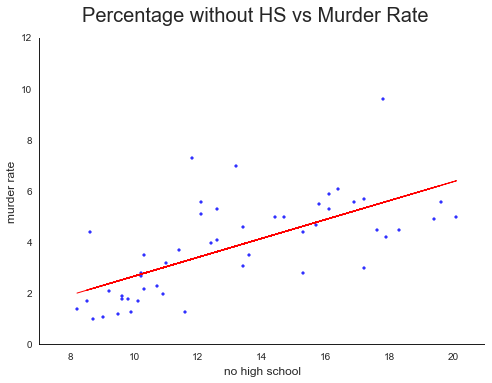

In [20]:
fit_and_plot(combined, 'Percentage without HS vs Murder Rate', 'no_high_school', 'murder_rate')
plt.xlim((7,21))
plt.axvline(7, color='black')

In [28]:
# Perform OLS fit
ols_fit = smf.ols('murder_rate ~ poverty_rate', data=combined).fit()
print ols_fit.pvalues
print ols_fit.summary()

Intercept       0.974790
poverty_rate    0.000127
dtype: float64
                            OLS Regression Results                            
Dep. Variable:            murder_rate   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     17.37
Date:                Tue, 16 Jun 2015   Prob (F-statistic):           0.000127
Time:                        18:14:00   Log-Likelihood:                -94.334
No. Observations:                  50   AIC:                             192.7
Df Residuals:                      48   BIC:                             196.5
Df Model:                           1                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept       -0.0304      0.957     -0.032      0.975      

Intercept      0.001415
murder_rate    0.000000
dtype: float64
                            OLS Regression Results                            
Dep. Variable:            murder_rate   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.696e+32
Date:                Tue, 16 Jun 2015   Prob (F-statistic):               0.00
Time:                        18:03:39   Log-Likelihood:                 1656.4
No. Observations:                  50   AIC:                            -3309.
Df Residuals:                      48   BIC:                            -3305.
Df Model:                           1                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    -1.11e-15   3.28e-16     -3.388      0.001     -1.77e

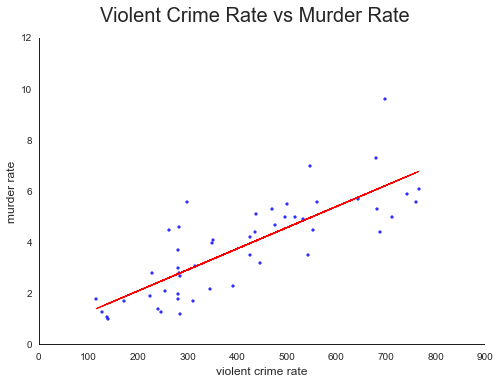

In [22]:
fit_and_plot(combined, 'Violent Crime Rate vs Murder Rate', 'violent_crime_rate', 'murder_rate')
#plt.xlim((7,21))
#plt.axvline(7, color='black')

In [26]:
# Perform OLS fit
ols_fit = smf.ols('murder_rate ~ high_school + poverty_rate', data=combined).fit()
print ols_fit.pvalues
print ols_fit.summary()

Intercept       0.000290
high_school     0.000273
poverty_rate    0.972780
dtype: float64
                            OLS Regression Results                            
Dep. Variable:            murder_rate   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     19.05
Date:                Tue, 16 Jun 2015   Prob (F-statistic):           8.71e-07
Time:                        18:08:17   Log-Likelihood:                -87.212
No. Observations:                  50   AIC:                             180.4
Df Residuals:                      47   BIC:                             186.2
Df Model:                           2                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept       35.6469      9.104   

In [29]:
# Perform OLS fit
ols_fit = smf.ols('murder_rate ~ no_high_school', data=combined).fit()
print ols_fit.pvalues
print ols_fit.summary()

Intercept         0.216383
no_high_school    0.000000
dtype: float64
                            OLS Regression Results                            
Dep. Variable:            murder_rate   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     38.92
Date:                Tue, 16 Jun 2015   Prob (F-statistic):           1.08e-07
Time:                        18:23:48   Log-Likelihood:                -87.213
No. Observations:                  50   AIC:                             178.4
Df Residuals:                      48   BIC:                             182.3
Df Model:                           1                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept         -1.0045      0.802     -1.253      0